In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss

from pycrostates.preprocessing import extract_gfp_peaks
from proof_of_consept import unit_normalize
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [138]:
"""{"temp": 33, "wind": "high"}
import dataclasses


@dataclasses.dataclass(frozen=True)
class Measurement:
    temp: int
    wind: str

print({Measurement(temp=2, wind="Very windy"): "this is a good measurment"})"""

{Measurement(temp=2, wind='Very windy'): 'this is a good measurment'}


In [135]:
"""a = (1, 2, 3)
b = a
a[0] = 100
print(b)"""

TypeError: 'tuple' object does not support item assignment

In [ ]:
"""
>>> my_stabilities = Stability().calc_stability(np.array([1, 3, 2]), np.array([4, 2, 9]), "dis")
>>> isinstance(my_stabilities, tuple)
True
>>> len(my_stabilities)
2
>>> my_stabilities  # doctest: +ELLIPSIS
(4.43..., 3.434...)

Error message if passed as lists

>>> Stability().calc_stability([1, 3, 2], [4, 2, 9], "dis")
Traceback (most recent call last):
...
TypeError: unsupported operand type(s) for -: 'list' and 'list'"""

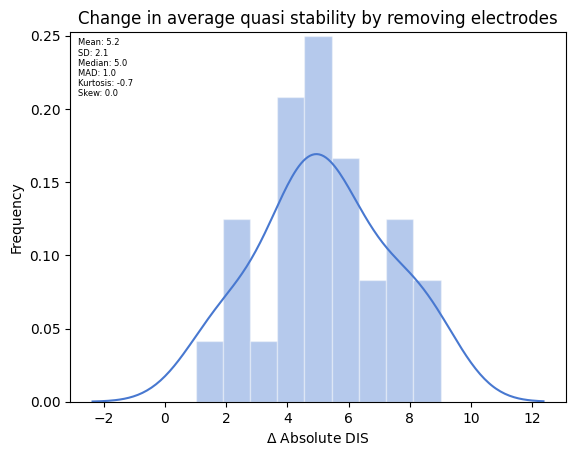

In [128]:
quasi_stab_change = np.array([1, 4, 2, 5, 6, 9, 7, 8, 5, 4, 6, 2, 9, 6, 5, 4, 3, 7, 4, 8, 4, 6, 5, 5, 5, 8, 2])
_, ax = plt.subplots()
sns.set_color_codes("muted")

t = sns.histplot(quasi_stab_change, kde=True, color='b', bins=9, stat='density', kde_kws={'cut':3}, alpha=.4, edgecolor=(1, 1, 1, .4))
max_y = t.dataLim.get_points()[-1][-1]*0.975
min_x = t.dataLim.get_points()[0][0]*1.2
ax.set_ylim([0.0,t.dataLim.get_points()[-1][-1]*1.01])
# set titles and label some text
ax.set_title("Change in average quasi stability by removing electrodes")
ax.set_xlabel(r'$\Delta$ ' + 'Absolute DIS')
ax.set_ylabel('Frequency')

ax.text(min_x, max_y, f'Mean: {round(np.mean(quasi_stab_change), 1)}', fontsize=6)

ax.text(min_x, max_y*0.97,f'SD: {round(np.std(quasi_stab_change), 1)}', fontsize=6)

ax.text(min_x, max_y*0.97*0.97,f'Median: {round(np.median(quasi_stab_change), 1)}', fontsize=6)

ax.text(min_x, max_y*0.97*0.97*0.97,f'MAD: {round(scipy.stats.median_abs_deviation(quasi_stab_change), 1)}', fontsize=6)

ax.text(min_x, max_y*0.97*0.97*0.97*0.97,f'Kurtosis: {scipy.stats.kurtosis(quasi_stab_change):.1f}', fontsize=6)

ax.text(min_x, max_y*0.97*0.97*0.97*0.97*0.97,f'Skew: {round(scipy.stats.skew(quasi_stab_change), 1)}', fontsize=6)
plt.show()

In [2]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [3]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\Data\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"


raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#Be carefull that artifact electrodes are not included in the average calc.
print(raw.info['ch_names'])
raw.set_montage('biosemi64')
#raw.drop_channels('O2')#raw.info["bads"].append("O2")
#mne.set_eeg_reference(raw, copy=False, verbose=False)
#raw.set_montage('biosemi64')

#bridged, dist = mne.preprocessing.compute_bridged_electrodes(raw)


raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=200, verbose=False)
raw_down_sampled.set_eeg_reference(ref_channels='average')
#I should maybe downsample, and maybe do it first for computational efficiency. The only thing is that then almost all the data will be in simpochs, so maybe I need stricter limits for gfp peakes.
#Bad segments can maybe be identified with Christoffers algorithm, anything else? I want to do this at the end of the pipeline I think.

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
[PCA] Explained variance of selected components : 63.02%
Power of components removed by DSS: 0.18
(245760, 64)
Creating RawArray with float64 data, n_channels=64, n_times=245760
    Range : 0 ... 245759 =      0.000 ...   239.999 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 64 x 48000 (240.0 s), ~23.5 MB, data loaded>

In [10]:
print(raw_down_sampled.get_data()[:, 8])

[ 1.06038049e-05  1.17395169e-05  6.91988818e-06 -9.24817414e-07
  1.86368425e-06  7.29469036e-06  1.24192619e-05  1.24431534e-05
  7.78692622e-06  3.62563342e-06 -6.01070927e-06 -1.18698844e-05
 -2.58932551e-06  2.07019805e-06  1.40301384e-05  6.75312677e-06
 -5.03982453e-06 -8.56878930e-06 -1.02437777e-05 -1.17541717e-05
 -1.11674413e-05 -6.62525327e-06 -4.57612878e-06  1.28428007e-06
 -1.08787909e-05 -8.90322230e-06 -7.81536603e-06 -2.89680132e-06
 -1.83367992e-07 -1.32604938e-05 -1.51535824e-05 -1.56344249e-05
  4.31831575e-06  4.54291672e-06  4.13772643e-06  9.55068723e-07
  5.27810286e-06 -2.56797028e-06 -4.65152342e-06 -1.21737874e-07
  4.33913976e-07  8.14308087e-06  7.83468862e-06  1.07030436e-06
 -7.99318065e-06 -8.97979803e-06 -9.77124574e-06 -1.36845117e-05
 -1.22480505e-05 -3.05373465e-06  2.38595623e-06  6.20851587e-06
  1.00538388e-05  4.29809542e-06 -5.57259359e-06 -1.14179136e-05
 -9.00569761e-06 -3.17839176e-07  6.66086622e-06  1.79588988e-05
  1.50676133e-05  3.36876

In [8]:
def gfp_normed_diss_data(indices, data, gfp):
    all_inx = np.arange(data.shape[1])
    unorderd_adj_indices = np.array([indices, (indices-1)]).flatten()
    anti_adj_indices = np.delete(all_inx, unorderd_adj_indices)
    all_inx = np.arange(data.shape[1])
    adj_indices = np.delete(all_inx, anti_adj_indices)

    indexed_data = data[:, adj_indices]
    indexed_gfp = gfp[adj_indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

def gfp_normed_diss_data2(indices, data, gfp):
    indexed_data = data[:, indices]
    indexed_gfp = gfp[indices]

    gfp_normed = indexed_data/indexed_gfp


    return gfp_normed

In [9]:
def diss(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices), data.shape[0]))
    for t in range(0, len(indices)*2, 2):
        diss[int(t/2), :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t+1])
    return diss

def diss2(data, gfp, indices):
    gfp_normed_data = gfp_normed_diss_data2(indices, data, gfp)
    diss = np.ndarray(shape=(len(indices)-1, data.shape[0]))
    for t in range(1, len(indices)):
        diss[t-1, :] = np.square(gfp_normed_data[:, t] - gfp_normed_data[:, t-1])
    return diss

In [10]:
def epoched_stability1(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stabilty = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        d = diss(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stabilty[e] = np.mean(for_convex)
    return stability, convex_stabilty

def epoched_stability2(epochs_object):
    epochs_array = epochs_object.get_data()
    stability = np.ndarray(shape=(epochs_array.shape[0]))
    convex_stability = np.ndarray(shape=(epochs_array.shape[0]))
    switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    significant_switching_freq = np.ndarray(shape=(epochs_array.shape[0]))
    peaks = np.ndarray(shape=(epochs_array.shape[0]))
    for e in range(epochs_array.shape[0]):
        data, indices, gfp, info_mne  = microstates_clean(epochs_array[e, :, :], standardize_eeg=False, normalize=False, gfp_method='l2', sampling_rate=epochs_object.info['sfreq'])
        if e == 0:
            data_at_peaks = data[:, indices]
            full_data = data
        else:
            data_at_peaks = np.concatenate((data_at_peaks, data[:, indices]), axis=1)
            full_data = np.concatenate((full_data, data), axis=1)
        d = diss2(data, gfp, indices)
        individual_map_stability = np.sqrt(np.mean(d, 1)) - 1
        for_convex = np.sqrt(np.mean(d, 1))
        freq = 0
        sfreq = 0
        for s in individual_map_stability:
            if s > 0:
                freq += 1
            if s > 0.4:
                sfreq += 1
        switching_freq[e] = freq
        significant_switching_freq[e] = sfreq
        stability[e] = np.mean(np.abs(individual_map_stability))
        convex_stability[e] = np.mean(for_convex)
        peaks[e] = len(indices)
    return stability, switching_freq, convex_stability, significant_switching_freq, peaks, full_data, data_at_peaks

Bad epoch idenfication - based on topographic stability

Between GFP peaks

In [11]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, overlap=0.5)

In [17]:
print(ones_epochs.events.shape)

(479, 3)


In [9]:
print(ones_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 200 original time points ...
0 bad epochs dropped
(479, 64, 200)


In [11]:
epoched_stability, epoched_switching_freq, convex_stabilty, significant_switching_freq, peaks, _, _ = epoched_stability2(ones_epochs)

Using data from preloaded Raw for 479 events and 200 original time points ...


Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

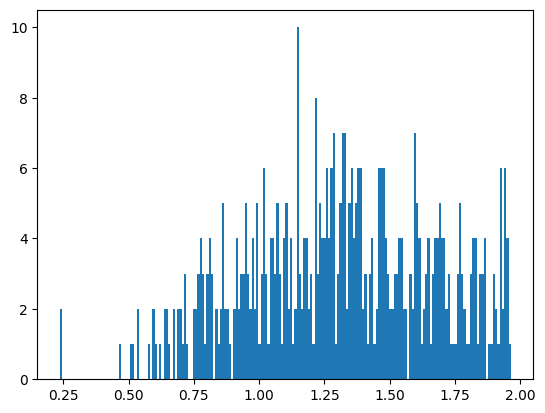

In [12]:
plt.hist(convex_stabilty, bins=200)
plt.show()

This is kind of a nonesesical plot as both 2 and 0 represents maximal stability. Stability values are therefor corrupted by averaging. Hovewer, the two timepoints idicating high stability by ways of low values (below 0.25) are clearly sepreated from the rest. These are epochs of high amplitude, low frequency noise. These are not corrupted by averageing as there is no polarity inversion happening, making them very distinct in the distribution. Question is are they seprable enough? What about very noisy EEG? Boxplot is not a good solution.

In [13]:
timepoints = np.where(convex_stabilty<0.6)[0]
print((timepoints)/2)

[100.5 101.  101.5 102.  158.  210.5 211.  211.5 229.5 230. ]


100.5-101 is this periode of high amplitude, low frequency noise. 158 and 210.5-211.5 is eyeblink artifacts I think. 229.5-230 not so sure. There are other periodes of eyeblink artifacts more apparent then the last one here.

Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

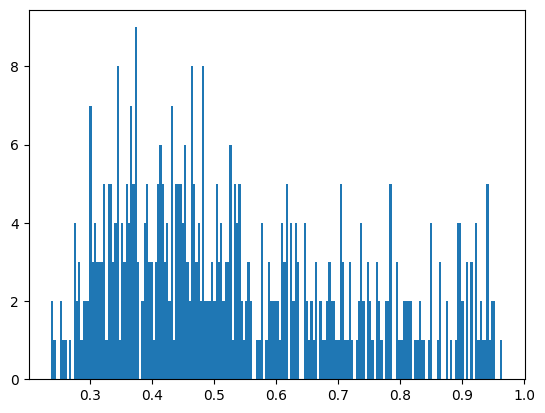

In [14]:
plt.hist(epoched_stability, bins=200)
plt.show()

In [15]:
timepoints = np.where(epoched_stability<0.25)[0]
print((timepoints)/2)

[ 66.  237.  238.5]


The most instable epochs do not look bad to me as expected. The most stable epochs looks like contains a lot of high amplitude alpha waves, but also the epoch with high amplitude, low frequency noise (stability value of approx 0.75 as expected).

Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

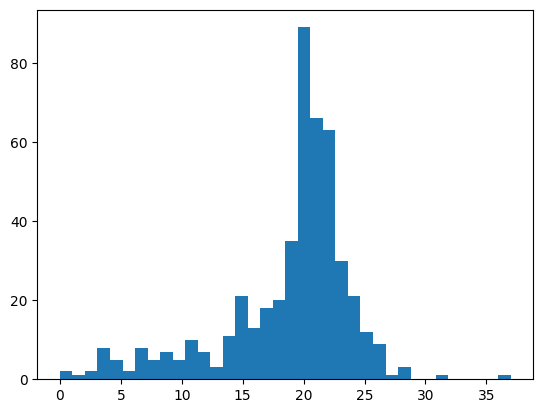

In [16]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

In [17]:
timepoints = np.where(epoched_switching_freq>30)[0]
print((timepoints)/2)

[110.  110.5]


These are moments with clear muscle artifacts.

In [18]:
timepoints = np.where(epoched_switching_freq>26)[0]
print((timepoints)/2)

[ 94.5  95.   95.5 110.  110.5 125.5]


The other time points does not look bad, and the muscle artifact is apperant before 110 s as well.

In [19]:
timepoints = np.where(epoched_switching_freq<3)[0]
print((timepoints)/2)

[101.  101.5 229.5]


Here we have the clearly bad epochs again, but 229.5 looks very good with clear nice alpha activity.

The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

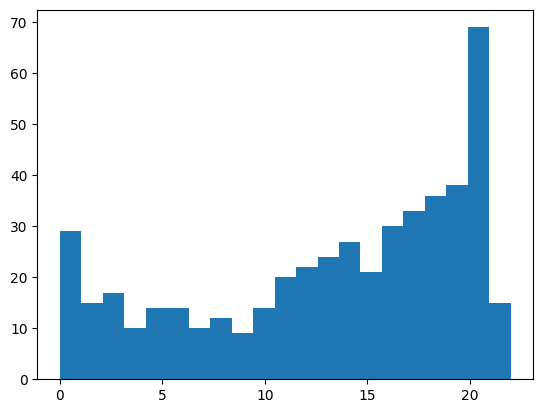

In [20]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

When looking at "significant" polarity inversions we see a lot of clean epocs also showing zero switching. This natural as several epochs will be in low GFP areas with low overall topographic stability.

In [21]:
timepoints = np.where(significant_switching_freq==0)[0]
print((timepoints)/2)

[ 85.  101.  210.5 212.  232.5]


Number of GFP peaks for each epoch

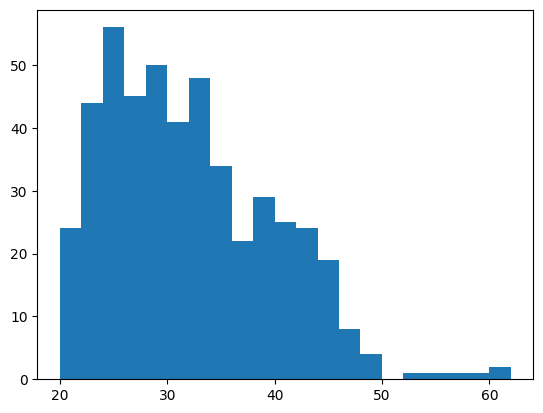

In [22]:
plt.hist(peaks, bins=21)
plt.show()

In [23]:
timepoints = np.where(peaks>50)[0]
print((timepoints)/2)

[109.  109.5 110.  110.5 111.  111.5]


Moments of muscle artifacts have more GFP peaks.

Looking at scatter plot between swithcing frequencies and number of GFP peaks

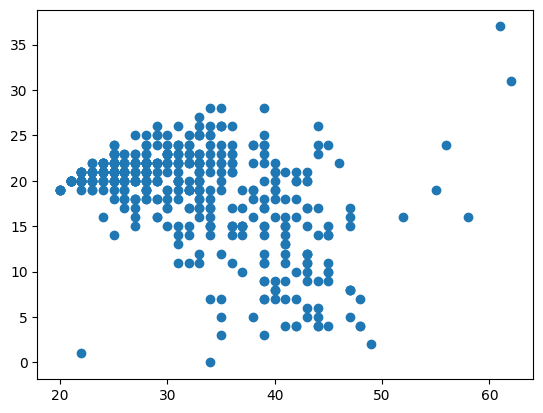

In [24]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

In [25]:
idx = np.where((epoched_switching_freq < 2))[0]
print((idx-1)/2)

[100.5 101. ]


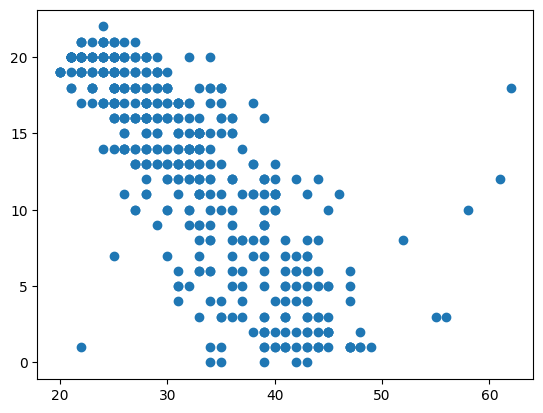

In [26]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

The more gfp peaks there are, the less significant switching we see. 

In [27]:
idx = np.where((peaks > 57))[0]
print(idx)
print((idx-1)/2)

idx = np.where((peaks < 28) & (significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((significant_switching_freq == 0))[0]
print((idx-1)/2)

[219 220 221]
[109.  109.5 110. ]
[101. 163.]
[ 84.5 100.5 210.  211.5 232. ]


What is becoming apparent is that moments of high amplitude low frequency noise don't experience a lot of polarity inversion. Hovewer these moments can show a varity of gfp peak numbers, mixing with none anomolous momments. Also in this section we see that not only do muscle artifacts experience a lot of GFP peaks but they also see few polarity inversions, but more inversions that moments of low stability EEG (that is clean). We might get a nice convex distribution here if we have EEG with a lot of muscle artifacts.

Looking at average absoluteDISS in relation to switching frequencies.

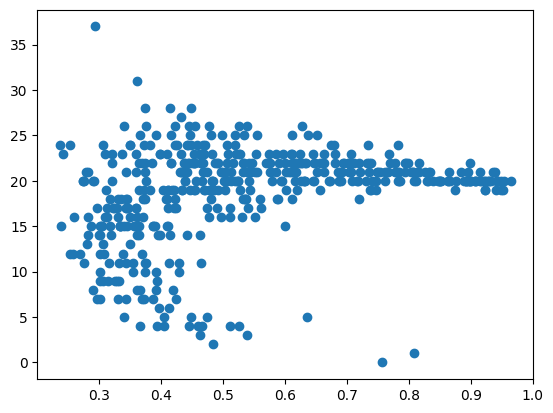

In [28]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

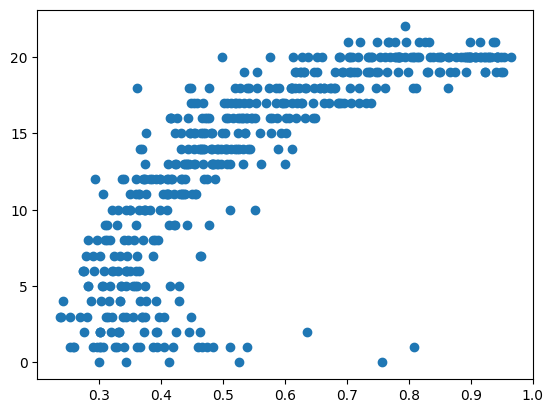

In [29]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

So here we see more clearly that very stable points not having a lot of "significant" polarity inversion sticks out as ouliers in this otherwise exponential looking distribution. In the scatter above muscle artifact outliers are easly visible to as those having low stability but a lot of "none-significant" polarity inversion.

In [30]:
idx = np.where((epoched_stability > 0.5) & (significant_switching_freq < 5))[0]
print((idx-1)/2)

[100.  100.5 101.  101.5 210.  210.5]


210 looks like clear eye artifact

Same but with average DISS

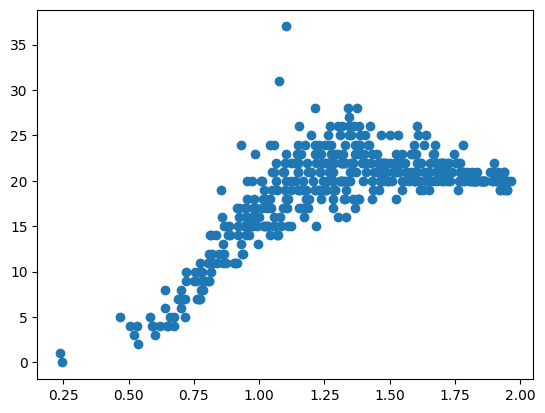

In [31]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

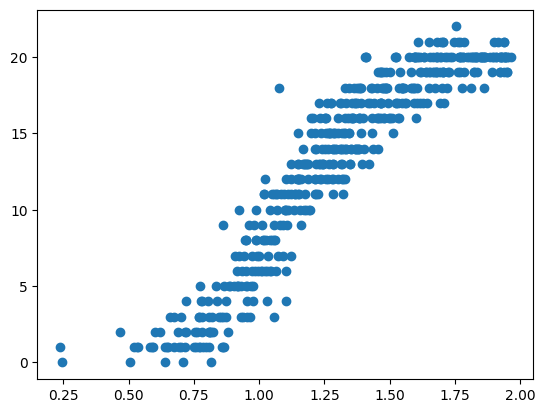

In [32]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

Nothing more to say here, a bit harder to deleaniate the moments of high aplitume low frequency noise.

In [33]:
print(epoched_stability[110*2], convex_stabilty[110*2], epoched_switching_freq[110*2], significant_switching_freq[110*2])

0.3615097105034908 1.0746830264454479 31.0 18.0


In [34]:
print(epoched_stability[int(109.5*2)], convex_stabilty[int(109.5*2)], epoched_switching_freq[int(109.5*2)], significant_switching_freq[int(109.5*2)])

0.35022873118578035 0.9234053006233729 16.0 10.0


In [35]:
print(epoched_stability[int(110.5*2)], convex_stabilty[int(110.5*2)], epoched_switching_freq[int(110.5*2)], significant_switching_freq[int(110.5*2)])

0.2931746425100933 1.1035400706191232 37.0 12.0


In [36]:
print(int(109.5*2)+1, 110*2)

220 220


Scatter of the two stability types

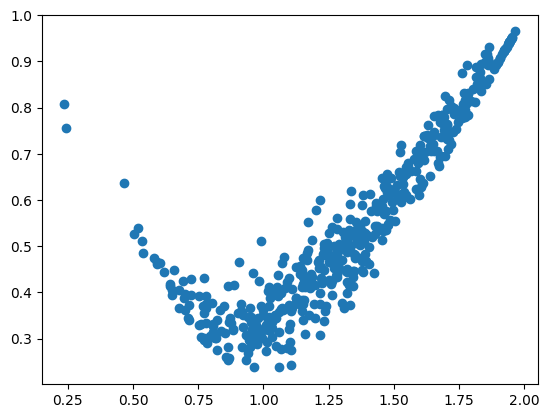

In [37]:
plt.scatter(convex_stabilty, epoched_stability)
plt.show()

In [1]:
idx = np.where((epoched_stability>0.6) & (convex_stabilty<0.75))[0]
print(idx)
print((idx)/2)

NameError: name 'np' is not defined

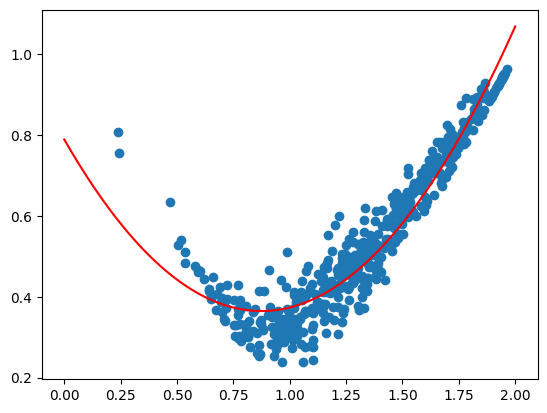

In [39]:
fit = np.poly1d(np.polyfit(convex_stabilty, epoched_stability, 2))
polyline = np.linspace(0, 2, 100)
plt.scatter(convex_stabilty, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()


In [40]:
print(fit)

        2
0.5556 x - 0.9713 x + 0.7892


Very interestingly alot of these epochs looks like they contain eye artifacts, in addition to the very bad epoch described several times. So question is; in this very clean eeg, what happens with these plots if we ICA extract th ecomponents?

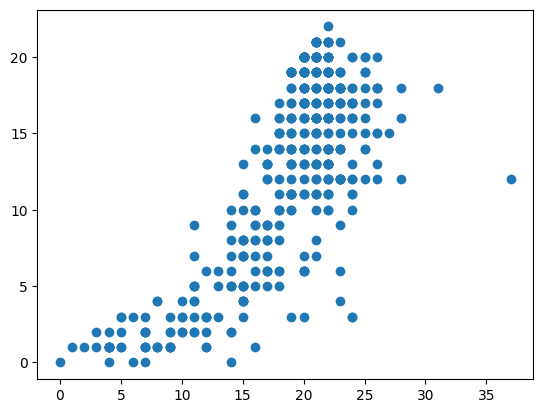

In [41]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

In [42]:
idx = np.where((epoched_switching_freq > 25) & (significant_switching_freq < 15))[0]
print((idx-1)/2)

[ 57.5 108.  110.  125. ]


In [43]:
channel_names = np.array(raw_down_sampled.info['ch_names'])

At GFP peaks

In [44]:
at_epoched_stability, at_convex_stabilty = epoched_stability1(ones_epochs)

Using data from preloaded Raw for 479 events and 200 original time points ...


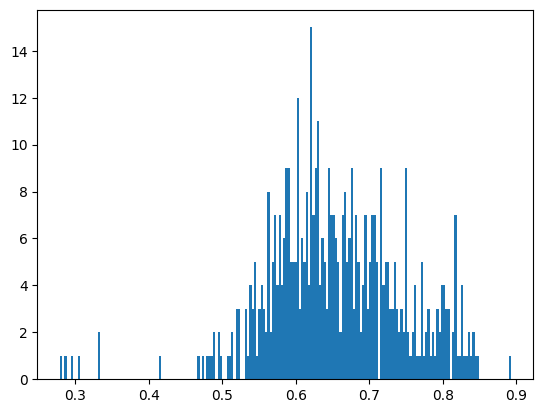

In [45]:
plt.hist(at_epoched_stability, bins=200)
plt.show()

In [46]:
idx = np.where(at_epoched_stability > 0.85)[0]
print((idx-1)/2)
idx = np.where(at_epoched_stability < 0.4)[0]
print((idx-1)/2)

[101.]
[108.  108.5 109.  109.5 110.  110.5]


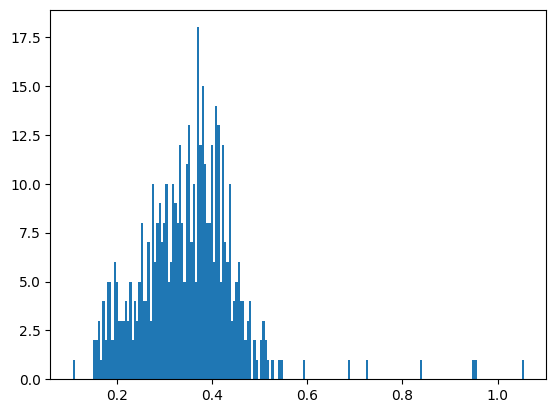

In [47]:
plt.hist(at_convex_stabilty, bins=200)
plt.show()

In [48]:
idx = np.where(at_convex_stabilty > 0.8)[0]
print((idx-1)/2)
idx = np.where(at_convex_stabilty < 0.15)[0]
print((idx-1)/2)

[108.5 109.  109.5 110. ]
[101.]


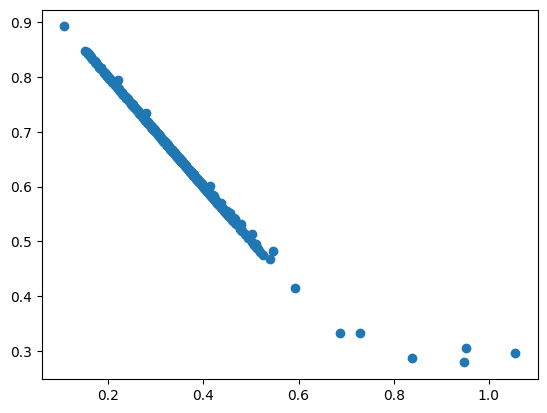

In [49]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

In [50]:
idx = np.where((at_convex_stabilty > 0.8) & (at_epoched_stability < 0.4))[0]
print((idx-1)/2)

[108.5 109.  109.5 110. ]


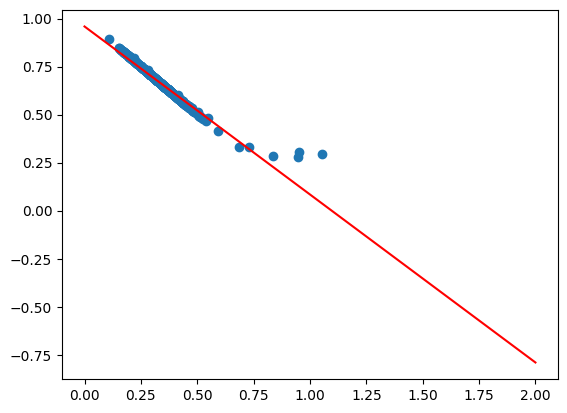

In [51]:
fit = np.poly1d(np.polyfit(at_convex_stabilty, at_epoched_stability, 1))
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()

In [52]:
print(fit)

 
-0.8744 x + 0.9587


What happens with ICA applied?

In [53]:
epocs_ica = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, overlap=0.5)
epocs_ica.drop([200, 201, 202, 203, 204, 205, 216, 217, 218, 219, 220, 221, 222]) #Removing the obv bad epochs.

Dropped 13 epochs: 200, 201, 202, 203, 204, 205, 216, 217, 218, 219, 220, 221, 222


Number of events,466
Events,1: 466
Time range,0.000 – 0.995 s
Baseline,off


In [54]:
ica_a = mne.preprocessing.ICA(max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True),
    )

In [55]:
ica_a.fit(epocs_ica)
#Do I feed enough data to ICA?

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Computing Extended Infomax ICA


Fitting ICA took 162.5s.


Method,infomax
Fit,500 iterations on epochs (93200 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


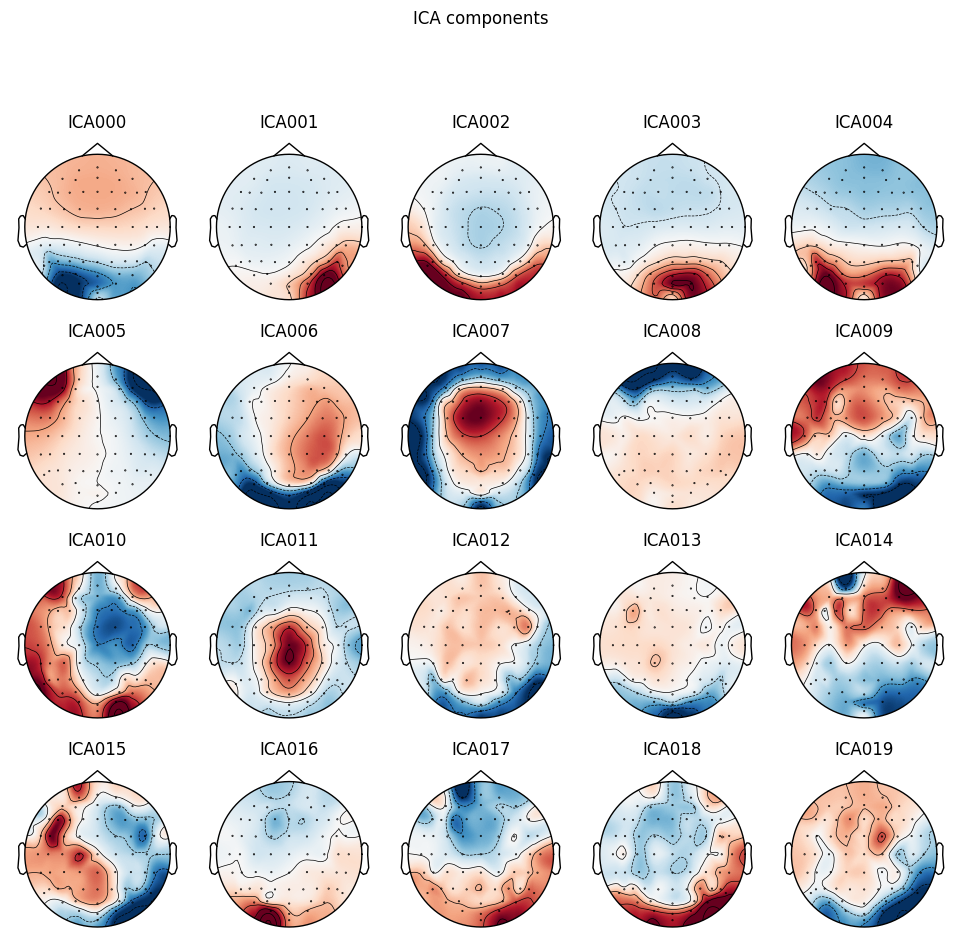

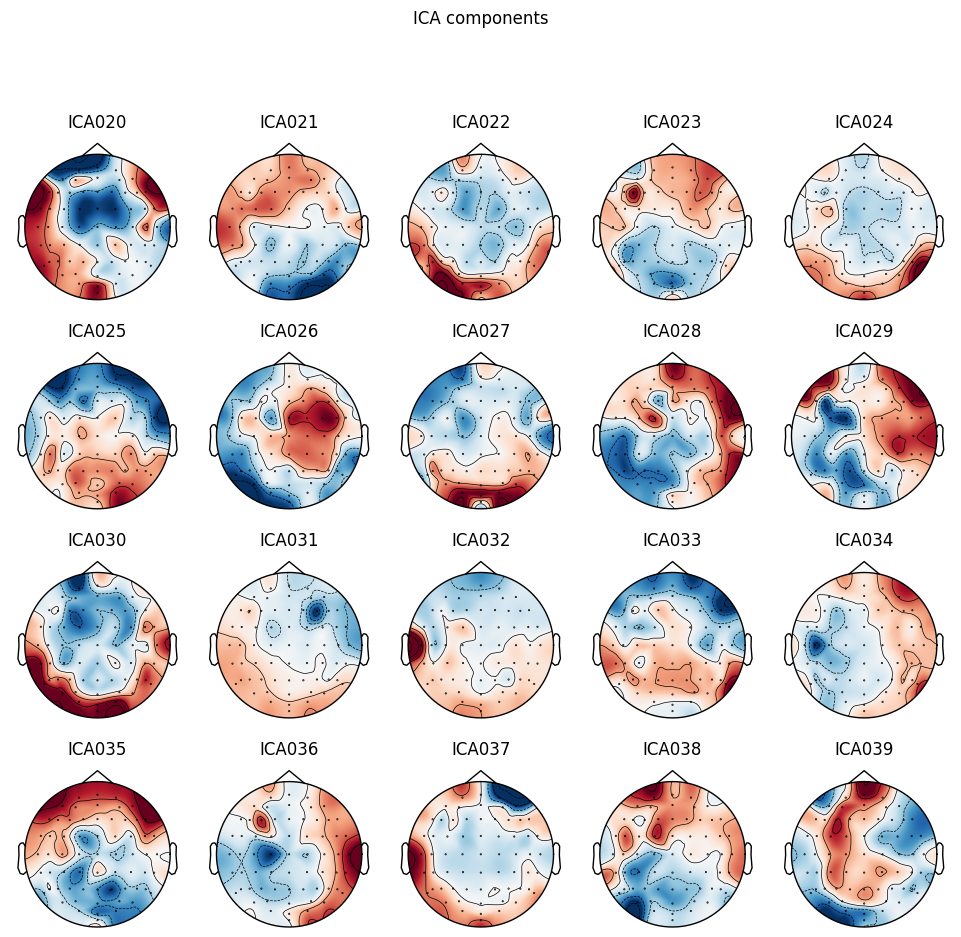

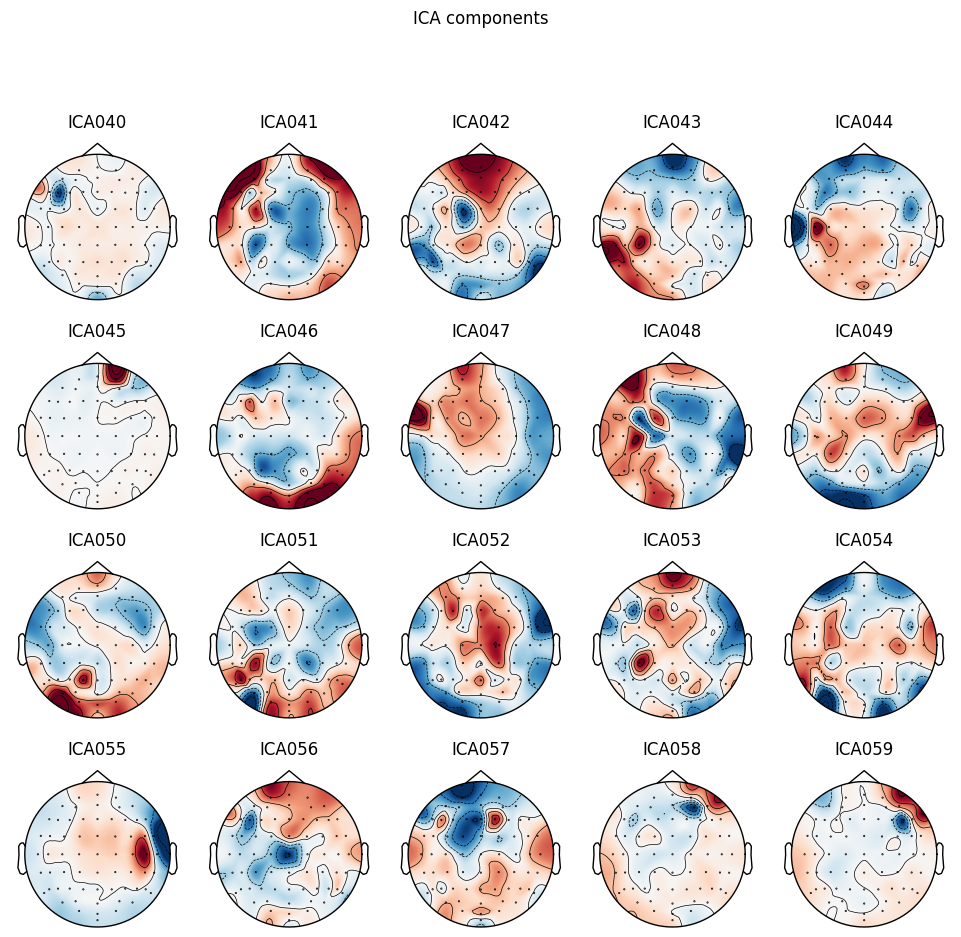

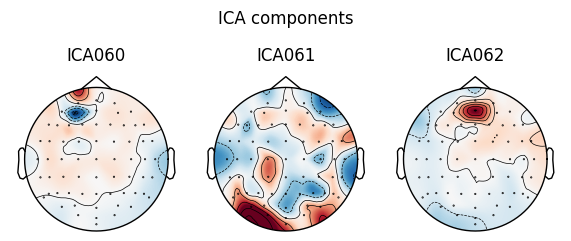

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 585x260.5 with 3 Axes>]

In [56]:
ica_a.plot_components()

In [57]:
ic_a_labels = label_components(raw_down_sampled, ica_a, method='iclabel')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [58]:
print(ic_a_labels)

{'y_pred_proba': array([0.9998381 , 0.99789655, 0.99031115, 0.99981374, 0.99981767,
       0.99981946, 0.96367925, 0.5368351 , 0.9846396 , 0.7348744 ,
       0.6967789 , 0.48184592, 0.568228  , 0.5466602 , 0.860168  ,
       0.57955873, 0.88424593, 0.58291435, 0.8966395 , 0.7919008 ,
       0.66877276, 0.7110021 , 0.9144845 , 0.74426883, 0.65859234,
       0.8860861 , 0.9040931 , 0.8324951 , 0.9774478 , 0.6655617 ,
       0.62796724, 0.599022  , 0.6451868 , 0.9117928 , 0.72902083,
       0.79859525, 0.9224788 , 0.82487476, 0.9956874 , 0.9905481 ,
       0.4277482 , 0.9248622 , 0.925082  , 0.9937878 , 0.9679669 ,
       0.98620605, 0.86376697, 0.622633  , 0.99837774, 0.6900198 ,
       0.5477701 , 0.97638834, 0.9479202 , 0.9919217 , 0.9650812 ,
       0.38283387, 0.90351564, 0.8215005 , 0.70176595, 0.5302042 ,
       0.67674774, 0.95264876, 0.9681332 ], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'eye blink', 'brain', 'brain', '

Very interesting that ICA is screaming channel noise for F5, the one PCA heuristic does not like, and the one stability analysis does not like after running ICA.

In [59]:
components = []
for ic in range(63):
    if ic_a_labels['y_pred_proba'][ic] > 0.8:
        if ic_a_labels['labels'][ic] == 'eye blink' or ic_a_labels['labels'][ic] == 'muscle artifact':
            components.append(ic)
            print(ic_a_labels['labels'][ic], ic_a_labels['y_pred_proba'][ic])
print(components)

eye blink 0.99981946
eye blink 0.9846396
muscle artifact 0.98620605
[5, 8, 45]


In [60]:
ica_a.exclude = components

In [61]:
reconstruction = ica_a.apply(epocs_ica)


Applying ICA to Epochs instance
    Transforming to ICA space (63 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


Between GFP peaks

In [63]:
ic_epoched_stability, ic_epoched_switching_freq, ic_convex_stabilty, ic_significant_switching_freq, ic_peaks, _, _ = epoched_stability2(epocs_ica)

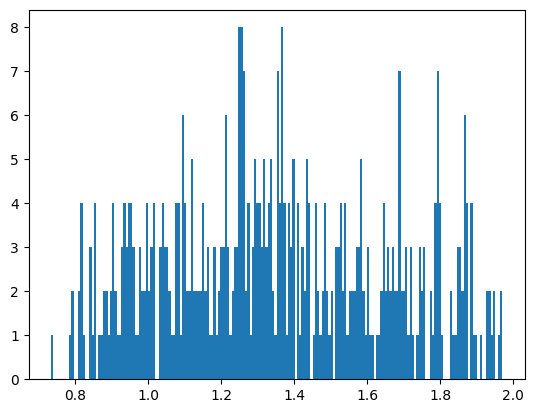

In [64]:
plt.hist(ic_convex_stabilty, bins=200)
plt.show()

In [65]:
timepoints = np.where(ic_convex_stabilty<0.6)[0]
print((timepoints)/2)

[]


Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

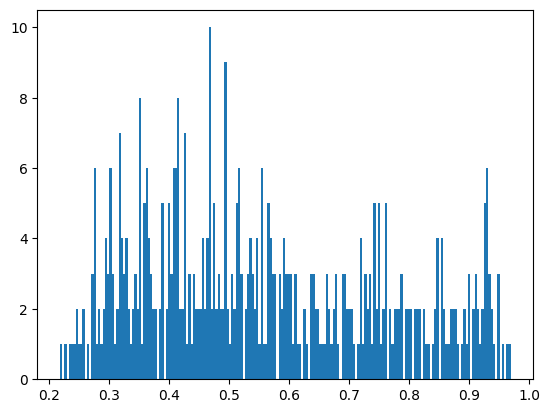

In [66]:
plt.hist(ic_epoched_stability, bins=200)
plt.show()

In [67]:
timepoints = np.where(ic_epoched_stability<0.25)[0]
print((timepoints)/2)

[ 66.   83.   89.   90.  205.  231.  231.5]


Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

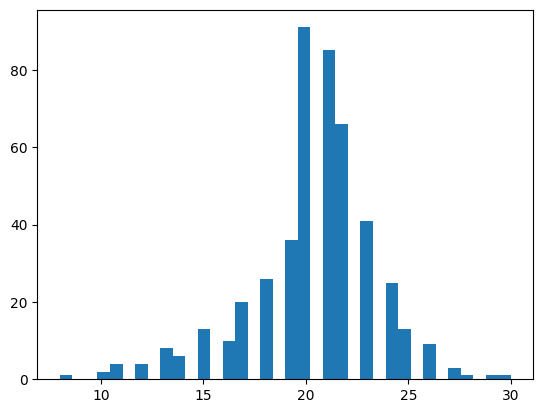

In [68]:
plt.hist(ic_epoched_switching_freq, bins=36)
plt.show()

In [69]:
timepoints = np.where(ic_epoched_switching_freq>30)[0]
print((timepoints)/2)

[]


The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

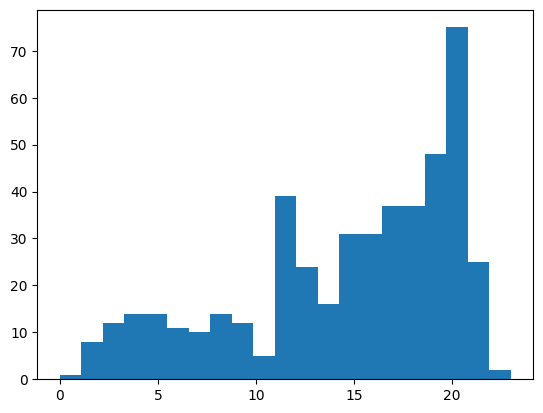

In [70]:
plt.hist(ic_significant_switching_freq, bins=21)
plt.show()

SO after ICA we dont see that anymore (zero switching epochs) , so maybe they were not clean.

Number of GFP peaks for each epoch

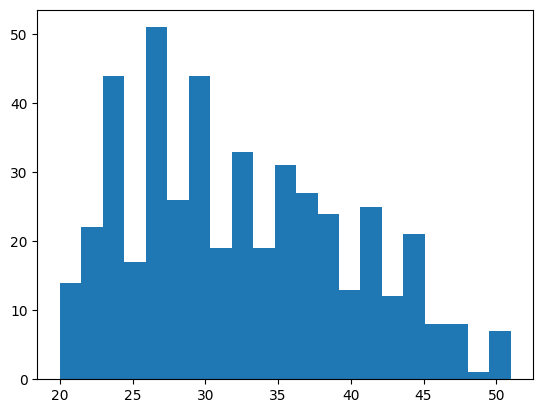

In [71]:
plt.hist(ic_peaks, bins=21)
plt.show()

In [72]:
timepoints = np.where(ic_peaks>50)[0]
print((timepoints)/2)

[ 91.5 109. ]


Looking at scatter plot between swithcing frequencies and number of GFP peaks

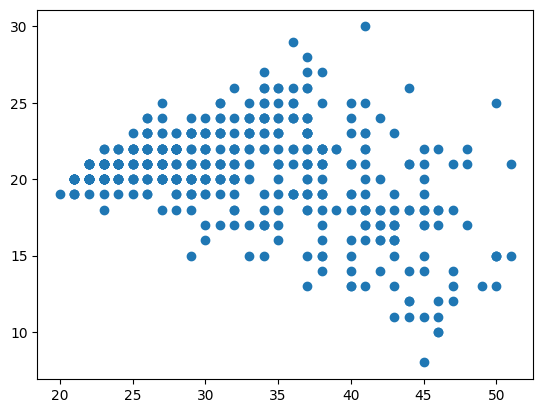

In [73]:
plt.scatter(ic_peaks, ic_epoched_switching_freq)
plt.show()

In [74]:
idx = np.where((ic_epoched_switching_freq < 2))[0]
print((idx-1)/2)

[]


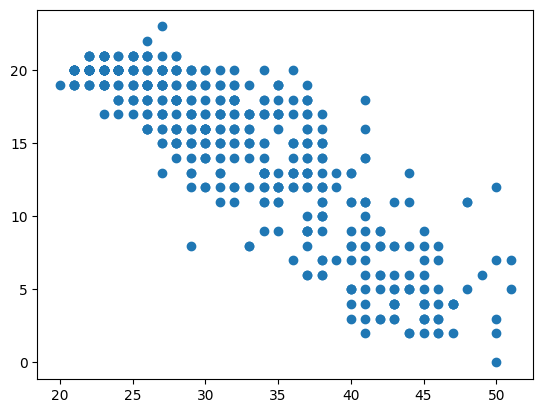

In [75]:
plt.scatter(ic_peaks, ic_significant_switching_freq)
plt.show()

In [76]:
idx = np.where((ic_peaks > 55))[0]
print(idx)
print((idx-1)/2)

idx = np.where((ic_peaks < 28) & (ic_significant_switching_freq < 9))[0]
print((idx-1)/2)

idx = np.where((ic_significant_switching_freq == 0))[0]
print((idx-1)/2)

[]
[]
[]
[85.]


Looking at average absoluteDISS in relation to switching frequencies.

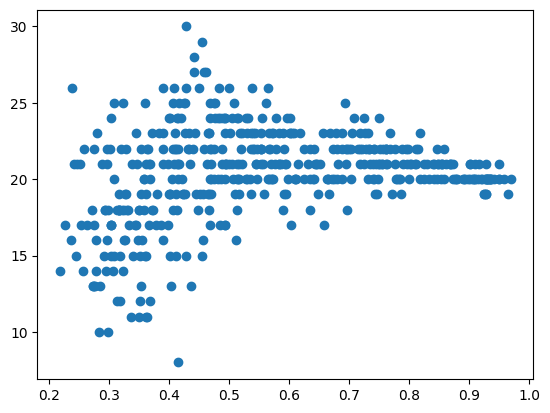

In [77]:
plt.scatter(ic_epoched_stability, ic_epoched_switching_freq)
plt.show()

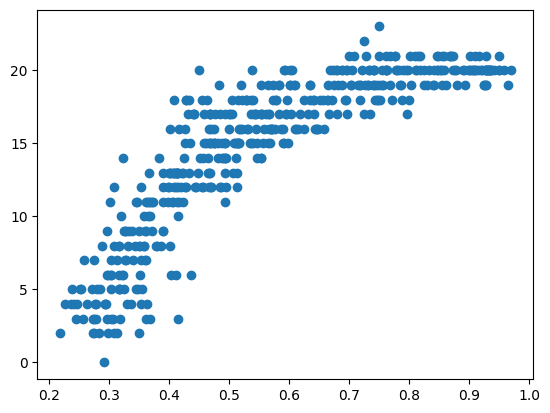

In [78]:
plt.scatter(ic_epoched_stability, ic_significant_switching_freq)
plt.show()

In [79]:
idx = np.where((ic_epoched_stability > 0.5) & (ic_significant_switching_freq < 5))[0]
print((idx-1)/2)

[]


Same but with average DISS

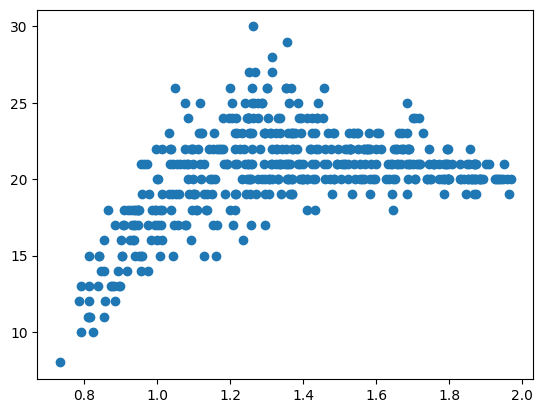

In [80]:
plt.scatter(ic_convex_stabilty, ic_epoched_switching_freq)
plt.show()

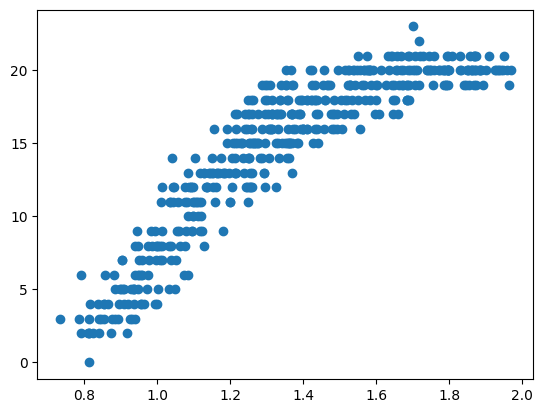

In [81]:
plt.scatter(ic_convex_stabilty, ic_significant_switching_freq)
plt.show()

In [82]:
print(ic_epoched_stability[218], ic_convex_stabilty[218], ic_epoched_switching_freq[218], ic_significant_switching_freq[218])

0.3030455484310151 0.904912324787835 15.0 7.0


In [83]:
print(ic_epoched_stability[int(109.5*2)], ic_convex_stabilty[int(109.5*2)], ic_epoched_switching_freq[int(109.5*2)], ic_significant_switching_freq[int(109.5*2)])

0.366969914314631 1.085534133955311 21.0 13.0


Scatter of the two stability types

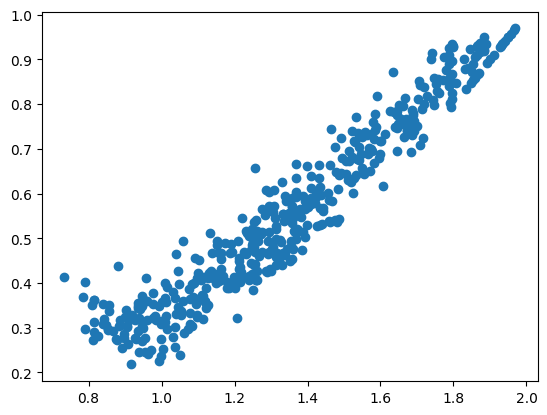

In [84]:
plt.scatter(ic_convex_stabilty, ic_epoched_stability)
plt.show()

In [85]:
idx = np.where((ic_epoched_stability>0.4) & (ic_convex_stabilty<0.75))[0]
print(idx)
print((idx)/2)

[304]
[152.]


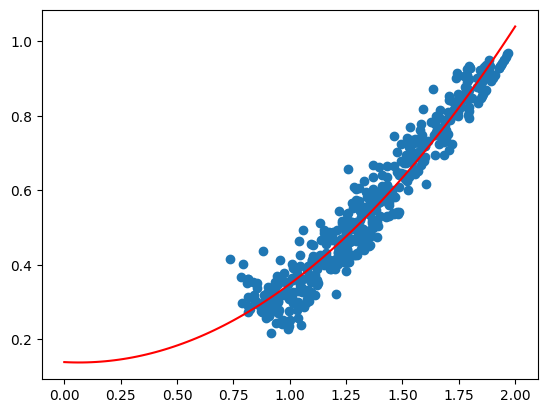

In [86]:
ic_fit = np.poly1d(np.polyfit(ic_convex_stabilty, ic_epoched_stability, 2))
ic_polyline = np.linspace(0, 2, 100)
plt.scatter(ic_convex_stabilty, ic_epoched_stability)
plt.plot(ic_polyline, ic_fit(polyline), color='red')
plt.show()


In [87]:
print(ic_fit)

        2
0.2409 x - 0.03144 x + 0.1386


So it augments the data kind of like i would expect.

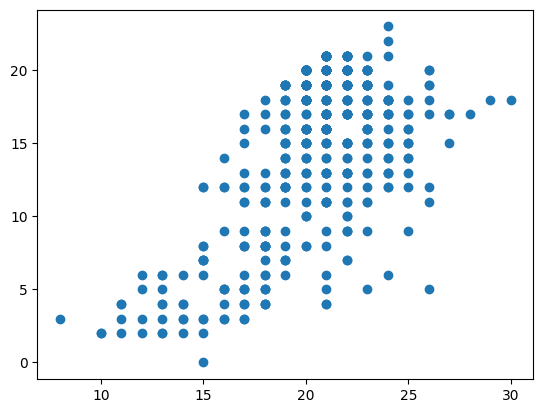

In [88]:
plt.scatter(ic_epoched_switching_freq, ic_significant_switching_freq)
plt.show()

In [89]:
idx = np.where((ic_epoched_switching_freq > 25) & (ic_significant_switching_freq < 15))[0]
print((idx-1)/2)

[31.5 36.  65.5]


At GFP peaks

In [90]:
ic_at_epoched_stability, ic_at_convex_stabilty = epoched_stability1(epocs_ica)

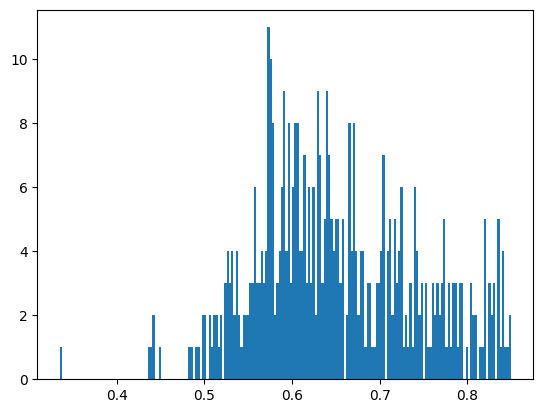

In [91]:
plt.hist(ic_at_epoched_stability, bins=200)
plt.show()

In [92]:
idx = np.where(ic_at_epoched_stability > 0.85)[0]
print((idx-1)/2)
idx = np.where(ic_at_epoched_stability < 0.4)[0]
print((idx-1)/2)

[]
[104.5]


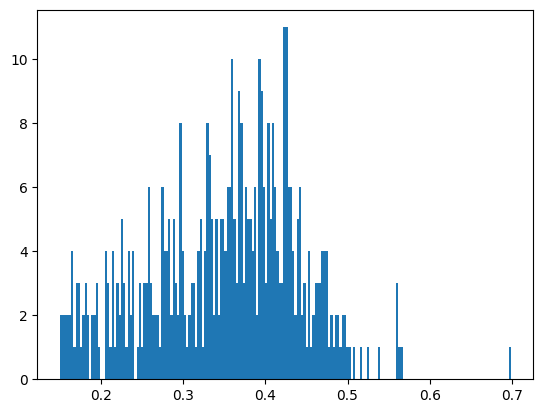

In [93]:
plt.hist(ic_at_convex_stabilty, bins=200)
plt.show()

In [94]:
idx = np.where(ic_at_convex_stabilty > 0.8)[0]
print((idx-1)/2)
idx = np.where(ic_at_convex_stabilty < 0.15)[0]
print((idx-1)/2)

[]
[]


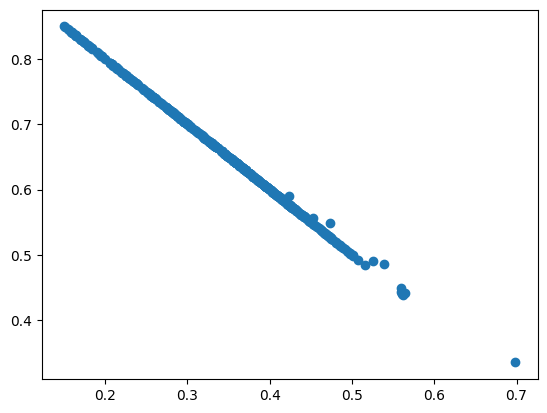

In [95]:
plt.scatter(ic_at_convex_stabilty, ic_at_epoched_stability)
plt.show()

In [96]:
idx = np.where((ic_at_convex_stabilty > 0.8) & (ic_at_epoched_stability < 0.4))[0]
print((idx-1)/2)

[]


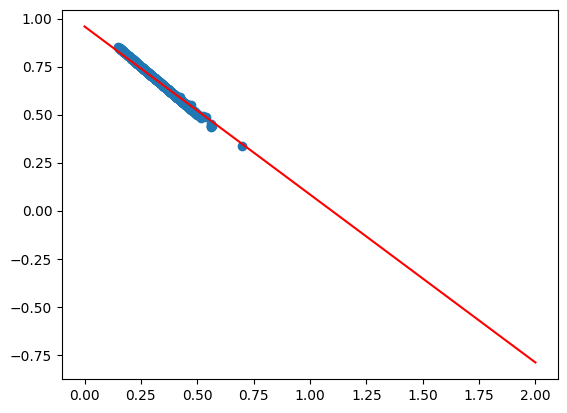

In [97]:
ic_at_fit = np.poly1d(np.polyfit(ic_at_convex_stabilty, ic_at_epoched_stability, 1))
polyline = np.linspace(0, 2, 100)
plt.scatter(ic_at_convex_stabilty, ic_at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.show()

In [98]:
print(ic_at_fit)

 
-0.9927 x + 0.9978


pca heuristic analysis

In [99]:
#idx = np.where((epoched_stability>=np.median(epoched_stability)) & (convex_stabilty>=np.median(convex_stabilty)) & (at_epoched_stability > np.median(at_epoched_stability)))[0]
#print(idx)

In [100]:
channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)

In [101]:
#anti_idx = np.arange(480)
#anti_idx = np.delete(anti_idx, idx)
#print(anti_idx)

In [102]:
#channelstab_epochs.drop(anti_idx)
channelstab_epochs.drop([200, 201, 202, 203, 204, 205, 216, 217, 218, 219, 220, 221, 222])

Dropped 13 epochs: 200, 201, 202, 203, 204, 205, 216, 217, 218, 219, 220, 221, 222


Number of events,467
Events,1: 467
Time range,0.000 – 0.495 s
Baseline,off


Channel Satbility

In [103]:
def remove_bad(mne_epoch_object, channel_name):
    raw = mne_epoch_object.copy()
    raw.drop_channels(channel_name)
    return raw

In [104]:
def leav_one_out(epochs_object):
    epoched_stability, _, _, _, _, _, _ = epoched_stability2(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _, _, _, _, _, _ = epoched_stability2(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

In [105]:
def leav_one_out2(epochs_object):
    epoched_stability, _ = epoched_stability1(epochs_object)
    ch_name_list = epochs_object.info['ch_names']
    basline_stability = np.mean(epoched_stability)
    stability_change = np.ndarray(shape=(len(ch_name_list)))
    for c in range(len(ch_name_list)):
        instance = remove_bad(epochs_object, ch_name_list[c])
        stab, _ = epoched_stability1(instance)
        stability_change[c] = basline_stability - np.mean(stab)        
    return stability_change

At GFP peaks

In [106]:
#channelstab_epochs = mne.make_fixed_length_epochs(raw_down_sampled, verbose=False, preload=True, duration=0.5)
at_test1 = leav_one_out2(channelstab_epochs)
#channelstab_epochs.drop([100, 101, 102, 108, 109, 110, 111])
test1 = leav_one_out(channelstab_epochs)

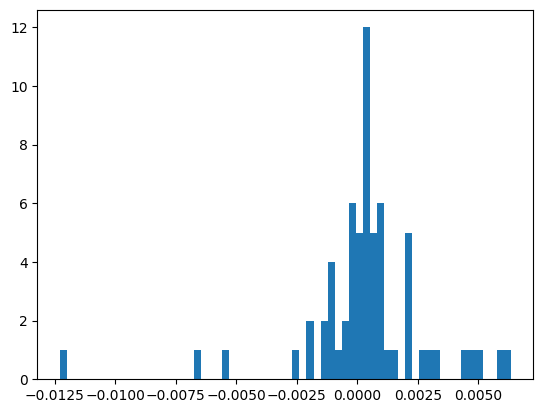

In [107]:
plt.hist(at_test1, bins=64)
plt.show()

In [108]:
order = np.argsort(at_test1)
print(channel_names[order])

['Fp2' 'Fp1' 'T7' 'AF8' 'FC6' 'AF3' 'C6' 'Fpz' 'T8' 'FT8' 'F5' 'F6' 'AF7'
 'C5' 'FC5' 'FT7' 'CP3' 'CP1' 'CP5' 'CP6' 'AF4' 'CP4' 'CP2' 'C4' 'P4' 'P1'
 'Pz' 'TP8' 'F8' 'C2' 'P2' 'FC4' 'F4' 'FC1' 'AFz' 'CPz' 'F3' 'C1' 'FC3'
 'P6' 'P3' 'TP7' 'Cz' 'F7' 'F1' 'F2' 'C3' 'FC2' 'Fz' 'P5' 'FCz' 'P8' 'PO3'
 'POz' 'P9' 'P7' 'PO4' 'P10' 'Iz' 'PO7' 'Oz' 'O1' 'PO8' 'O2']


Between GFP peaks

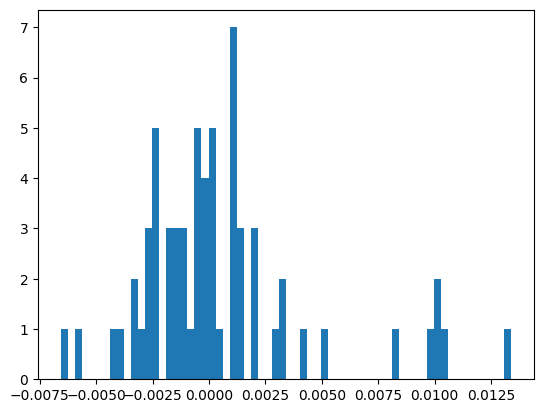

In [109]:
plt.hist(test1, bins=64)
plt.show()

In [127]:
def _threshold_find_bad_channels(stabilities, threshold=None):
    if threshold is None:
        # do default
        return "somehitng"
    
    return stabilities[stabilities < threshold]
    

def _greedy_right_tail_exclusion(stabilities):
    """This performs greedy exclusoipn of bad channels by iteratively removing the least stable electrodes, terminating when ..."""
    raise NotImplementedError


def find_bad_channels(stabilities, method="threshold", **kwargs):
    if method == "threshold":
        return _threshold_find_bad_channels(stabilities, **kwargs)
    else:
        raise ValueError("Mate, give me something real")



SyntaxError: invalid syntax (1472629850.py, line 1)

In [ ]:
# Some configurations
t_min = -0.008
t_max = 0.0
step = 0.0001
method = "new_method"

num_bad_channels = []
for treshold in range(t_min, t_max, step):
    bad_channels = find_bad_channels(stabilities, method=method, threshold=treshold)

    num_bad_channels.append(len(bad_channels))





In [110]:
order = np.argsort(test1)
print(channel_names[order])

['Fp1' 'Fp2' 'C6' 'AF7' 'F5' 'FT8' 'T8' 'FC6' 'FC5' 'AF8' 'T7' 'F7' 'C5'
 'FT7' 'CP3' 'F8' 'TP8' 'Fpz' 'CP1' 'F6' 'CP6' 'Pz' 'CP4' 'CPz' 'FC3'
 'CP5' 'P1' 'TP7' 'CP2' 'C1' 'C2' 'P4' 'P2' 'FC1' 'AF3' 'P3' 'C4' 'F3'
 'Cz' 'C3' 'F4' 'AF4' 'FC2' 'AFz' 'P5' 'F1' 'FCz' 'P6' 'POz' 'FC4' 'F2'
 'P7' 'Fz' 'P9' 'PO3' 'P8' 'P10' 'PO4' 'PO7' 'PO8' 'Iz' 'Oz' 'O1' 'O2']


In [111]:
print(kurtosis(test1))
print(skew(test1))

2.122997349963126
1.399111233962127


PCA heuristic idea

In [112]:
print(ones_epochs.get_data().shape)
print(channelstab_epochs.get_data().shape)

Using data from preloaded Raw for 479 events and 200 original time points ...
(479, 64, 200)
(467, 64, 100)


In [113]:
_, _, _, _, _, data_all, data_at_peaks = epoched_stability2(channelstab_epochs)

In [114]:
data = data_at_peaks.T

In [115]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

In [116]:
def pca_auc(data):
    pca = sklearn.decomposition.PCA(random_state=9)
    pca.fit_transform(data)
    roc_curve = np.ndarray(shape=pca.components_.shape[0])
    explained_var = pca.explained_variance_ratio_
    percent = 0
    for v in range(roc_curve.shape[0]):
        percent += explained_var[v]
        roc_curve[v] = percent
    auc = np.trapz(roc_curve.flatten())
    return auc/pca.components_.shape[0], roc_curve

0.9444145374824219


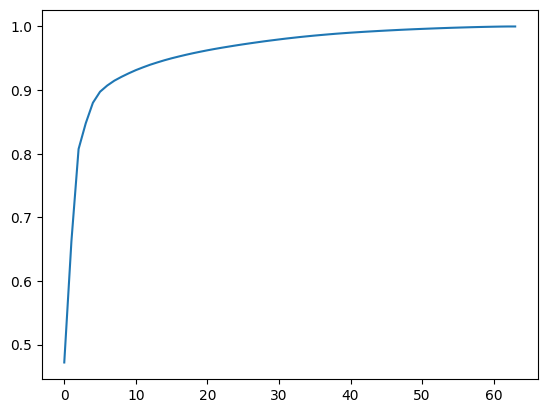

In [117]:
benchmark, rc = pca_auc(data)
print(benchmark)
plt.plot(rc)
plt.show()

In [118]:
pc_all_chanels = np.ndarray(64)
for c in range(len(channel_names)):
    dataaa = np.delete(data, c, axis=1)
    b, r = pca_auc(dataaa)
    pc_all_chanels[c] = b-benchmark

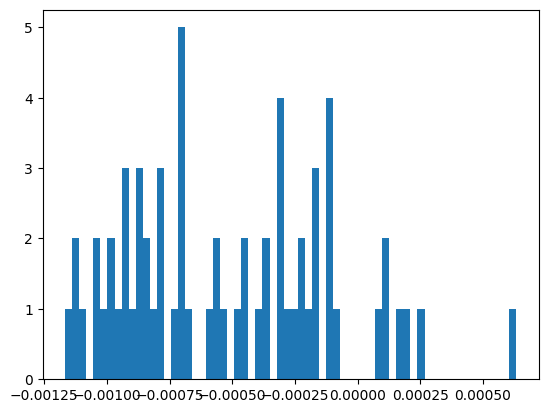

In [119]:
plt.hist(pc_all_chanels, bins=64)
plt.show()

In [120]:
order = np.argsort(pc_all_chanels)
print(channel_names[order])

['O2' 'Oz' 'O1' 'PO8' 'PO3' 'P8' 'Fz' 'F2' 'PO4' 'AFz' 'P7' 'POz' 'P5'
 'FCz' 'FC4' 'Iz' 'PO7' 'C2' 'F4' 'P6' 'FC2' 'P10' 'F7' 'AF4' 'P3' 'FT7'
 'F6' 'Cz' 'F8' 'P9' 'Pz' 'P2' 'TP7' 'TP8' 'AF3' 'Fpz' 'F1' 'F3' 'CP6'
 'CP4' 'P1' 'AF7' 'FC5' 'CP5' 'FT8' 'CPz' 'P4' 'C4' 'C3' 'C6' 'AF8' 'CP1'
 'CP2' 'Fp1' 'FC6' 'FC3' 'C1' 'FC1' 'Fp2' 'T8' 'C5' 'T7' 'F5' 'CP3']


In [121]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(channel_names[bad_by_corr])

['F5' 'FC1' 'C5' 'T7' 'CP3' 'Fp2' 'T8']


In [122]:
idx = np.where((at_test1 < 0) & (test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 5 13 14 17 33 51]


In [123]:
print(channel_names[idx])

['F5' 'C5' 'T7' 'CP3' 'Fp2' 'T8']


In [124]:
idx = np.where((at_test1 < 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 < 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 5 13 14 17 33 51]
[ 5 10 13 14 17 33 51]


In [125]:
print(channel_names[idx])
print(channel_names[idx2])

['F5' 'C5' 'T7' 'CP3' 'Fp2' 'T8']
['F5' 'FC1' 'C5' 'T7' 'CP3' 'Fp2' 'T8']


Channels to exclude

In [126]:
acum = []
for cn in channel_names[np.argsort(test1)]:
    if cn in channel_names[bad_by_corr]:
        print(cn)
        acum.append(cn)
    else:
        break
for cn in channel_names[np.argsort(at_test1)]:
    if cn in channel_names[bad_by_corr]:
        if cn not in acum:
            print(cn)
    else:
        break


Fp2
